# Scratchpad for Purchase Analysis

### Imports

In [100]:
import datetime
import glob
import os
import re
import time
import matplotlib.pyplot as plt
import pandas as pd
import requests
import statsmodels.api as sm
import scipy as sp
from bs4 import BeautifulSoup
from matplotlib import rcParams
from matplotlib.ticker import EngFormatter
from matplotlib.ticker import MaxNLocator
import urllib


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 50)  # or 1000



### Constants

In [2]:
RE_NO_BREAK_SPACE = re.compile(r"( )")
KEYS = []
NOW = datetime.datetime.now().strftime('%Y_%m_%d')
COLOURS = ['#db5f57', '#dbc257', '#91db57', '#57d3db', '#5770db', '#a157db', '#db57b2']
URLS_P24 = [
    "https://www.property24.com/for-sale/sea-point/cape-town/western-cape/11021",
    "https://www.property24.com/for-sale/observatory/cape-town/western-cape/10157",
    "https://www.property24.com/for-sale/gardens/cape-town/western-cape/9145",
    "https://www.property24.com/for-sale/cape-town-city-centre/cape-town/western-cape/9138",
    "https://www.property24.com/for-sale/rondebosch/cape-town/western-cape/8682",
    "https://www.property24.com/for-sale/muizenberg/cape-town/western-cape/9025",
    "https://www.property24.com/for-sale/constantia/cape-town/western-cape/11742",
    "https://www.property24.com/for-sale/woodstock/cape-town/western-cape/10164",
    "https://www.property24.com/for-sale/newlands/cape-town/western-cape/8679",
    "https://www.property24.com/for-sale/green-point/cape-town/western-cape/11017",
    "https://www.property24.com/for-sale/claremont-upper/cape-town/western-cape/14225",
    "https://www.property24.com/for-sale/plumstead/cape-town/western-cape/10094",
    "https://www.property24.com/for-sale/camps-bay/cape-town/western-cape/11014",
    "https://www.property24.com/for-sale/claremont/cape-town/western-cape/11741",
    "https://www.property24.com/for-sale/fresnaye/cape-town/western-cape/11016"
]
URLS_CARS = [
    "https://www.cars.co.za/searchVehicle.php?new_or_used=Used&make_model=&vfs_area=Western+Cape&agent_locality=&price_range=50000+-+74999%7C75000+-+99999%7C100000+-+124999%7C125000+-+149999&os=&locality=&body_type_exact=Hatchback&transmission=&fuel_type=&login_type=&mapped_colour=black%7Cgrey%7Csilver&vfs_year=&vfs_mileage=&vehicle_axle_config=&keyword=&sort=vfs_price",
]
URLS_AUTOTRADER = [
    "https://www.autotrader.co.za/cars-for-sale/western-cape/p-9?price=50001-to-200000&bodytype=hatchback&bodytype=sedan&colour=Black&colour=Grey&colour=Silver&colour=White&isused=True",
]
URLS_WEBUYCARS = [
    "https://www.webuycars.co.za/buy-a-car?subcategory=Hatchback&DealerKey=%5B%22Cape%20Town%202%20Phumelela%20Park%20Branch%22,%22Cape%20Town%201%20Montague%20Drive%20Branch%22%5D&Priced_Amount_Gte=50000&Priced_Amount_Lte=150000&BodyType=%5B%22Hatchback%22%5D&Colour=%5B%22Silver%22,%22White%22,%22Grey%22,%22Black%22%5D&page=1"
]
IN_DEVELOPMENT = True

# Prices of cars with Bluetooth

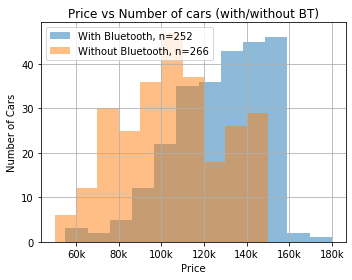

In [78]:
csv_path = "CSVs/2019_11_21/www.cars.co.za.csv"
df = pd.read_csv(csv_path)
bt = df[df["features_bluetooth"] == True]
not_bt = df[df["features_bluetooth"] == False]
num_bins_bt = int(round((bt["price"].max() - bt["price"].min()) / 10000, 0))
num_bins_not_bt = int(round((not_bt["price"].max() - not_bt["price"].min()) / 10000, 0))


fig, ax = plt.subplots(figsize=(5, 4))
plt.grid(True)
ax.xaxis.set_major_formatter(EngFormatter(sep=""))

ax.hist(bt["price"], bins=num_bins, alpha=0.5, label=f"With Bluetooth, n={len(bt['price'].index)}")
ax.hist(not_bt["price"], bins=num_bins_not_bt, alpha=0.5, label=f"Without Bluetooth, n={len(not_bt['price'].index)}")

ax.set_title("Price vs Number of cars (with/without BT)")
ax.set_xlabel("Price")
ax.set_ylabel("Number of Cars")
ax.legend(loc='best')

plt.tight_layout()
plt.savefig("readme_resources/bt_hist.png")
plt.show()


In [151]:
df1 = sorted(df["colour"].unique().astype(str))
colours = {
    "white": re.compile("(white)"),
    "grey": re.compile("(grey|gray|charcoal)"),
    "silver": re.compile("(silver)"),
    "black": re.compile("(black)"),
    "nan": re.compile("(nan)"),
    "blue": re.compile("(blue|sea)"),
    "orange": re.compile("(orange)"),
    "red": re.compile("(pepper|red)"),
}

In [155]:
actual = []
for i, item in enumerate(df1):
    actual.append([item])
    for k, v in colours.items():
        if re.search(v, item):
            actual[i].append(k)


# Print out images of the different models

In [80]:
csv_path = "CSVs/2019_11_21/www.cars.co.za_pruned.csv"
df = pd.read_csv(csv_path)

In [81]:
print("Starting")
models = list(df["model"].unique())
# models
image_links = []
for i, row in df.iterrows():
    if row["model"] in models and not pd.isna(row["img_link"]):
#         print(row["img_link"])
        image_links.append((row["img_link"], row["model"]))
        models.remove(row["model"])


Starting


29
.............................
Plotting


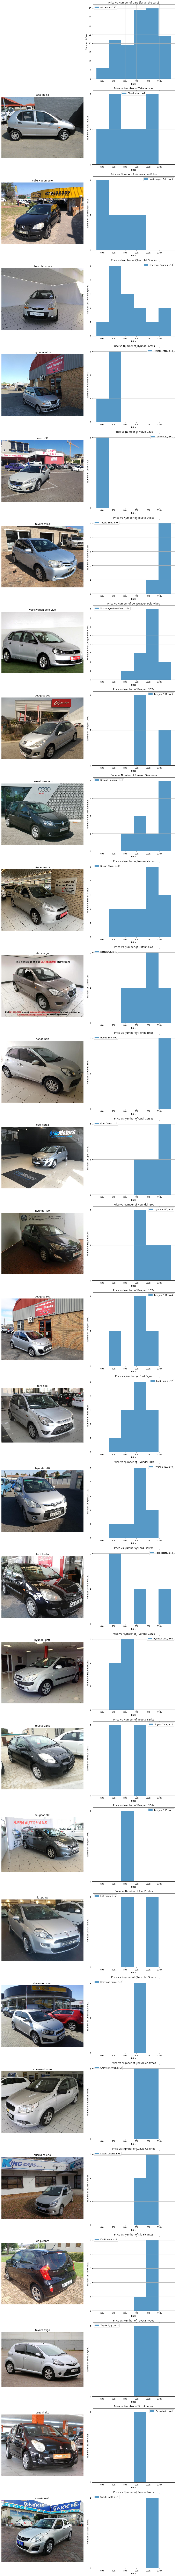

In [82]:
# image_links = image_links[:4]
fig, axes = plt.subplots(len(image_links) + 1, 2, 
                         figsize=(12, 6*len(image_links)), 
                        sharex='col')
plt.grid(True)
num_bins = int(round((df["price"].max() - df["price"].min()) / 10000, 0))
n, bins, patches = axes[0, 1].hist(
    df["price"], 
    bins=num_bins,
    alpha=0.75, 
    label=f"All cars, n={len(df.index)}")
axes[0, 0].axis("off")
axes[0, 1].tick_params(axis='x', reset=True)
axes[0, 1].set_title(f"Price vs Number of Cars (for all the cars)")
axes[0, 1].set_xlabel("Price")
axes[0, 1].set_ylabel(f"Number of Cars")
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True)
axes[-1, 1].set_xticks(range(
    int(round(df["price"].min(), -4)), 
    int(round(df["price"].max(), -4)), 
    10000))

print(len(image_links))
for i, (link, model) in enumerate(image_links):
    print(".", end="")
    curr_model = df[df["model"] == model]
    axes[i+1, 1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[i+1, 1].grid(True)
    axes[i+1, 1].xaxis.set_major_formatter(EngFormatter(sep=""))
    axes[i+1, 1].tick_params(axis='x', reset=True)
    axes[i+1, 1].set_xticks(axes[-1, 1].get_xticks())
    axes[i+1, 1].hist(curr_model["price"], 
                      bins=bins, 
                      alpha=0.75, 
                      label=f"{model.title()}, n={len(curr_model.index)}")
    axes[i+1, 1].set_title(f"Price vs Number of {model.title()}s")
    axes[i+1, 1].set_xlabel("Price")
    axes[i+1, 1].set_ylabel(f"Number of {model.title()}s")
    axes[i+1, 1].legend(loc='best')
    try:
        f = urllib.request.urlopen(link)
        a = plt.imread(f, format='jpg')
        axes[i+1, 0].imshow(a)
        axes[i+1, 0].set_title(model)
        axes[i+1, 0].axis('off')
    except:
        pass
print("\nPlotting")
plt.tight_layout()
plt.savefig("readme_resources/models_vs_price.png")

In [ ]:
# models = list(df["model"].unique())
# tata = df[df["model"] == "tata indica"]
# # not_bt = df[df["features_bluetooth"] == False]

# fig, ax = plt.subplots(2, figsize=(6, 8))
# n, bins, patches = ax[1].hist(df["price"], alpha=0.5, label="All cars")
# ax[0].hist(tata["price"], bins=bins, alpha=0.5, label="tata indica")
# # ax[0].hist(not_bt["price"], bins=bins,alpha=0.5, label="Without Bluetooth")


# ax[0].set_title("Price vs Number of cars (tata)")
# ax[0].set_xlabel("Price")
# ax[0].set_ylabel("Number of Cars")
# ax[0].legend(loc='best')

# ax[1].set_title("Price vs Number of cars (For all cars)")
# ax[1].set_xlabel("Price")
# ax[1].set_ylabel("Number of Cars")
# ax[1].legend(loc='best')

# plt.tight_layout()
# # plt.show()
# # plt.savefig("readme_resources/bt_hist.png")

nice_models = [
 'volkswagen polo',
 'volvo c30',
 'volkswagen polo vivo',
 'peugeot 207',
 'renault sandero',
 'datsun go',
 'opel corsa',
 'hyundai i20',
 'audi a3',
 'hyundai getz',
 'toyota yaris',
 'peugeot 208',
 'fiat punto',
 'chevrolet sonic',
 'chevrolet aveo',
 'kia picanto',
 'suzuki alto',
 'suzuki swift']
nice_models

In [79]:
df1 = df[df["model"] == "ford figo"]
